In [70]:
# Run code on Anaconda Env.
# Construct data source by downloading 2018 data
import folktables
from folktables import ACSDataSource, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)  # have to use 'download=True' if data not already avaiable locally

features, label, group = ACSIncome.df_to_numpy(acs_data)  # split data into corresponding features, labels, and group



In [72]:
def mixRaceRates(data, target_bhn_ratio):
    # Input: complete training dataset as numpy array
    # Output: filtered dataset where ratio of bhn indiviudals satisfies the desired target (+/- 1%)
    # RAC1P column # for ASCIncome task -> 9

    # count occurances of BHN in the RAC1P column
    rac1p_values = data[:, 9]
    bhn_count = np.count_nonzero(rac1p_values == 2) + np.count_nonzero(rac1p_values == 3)
    
    # calc current ratio
    current_ratio = bhn_count / len(rac1p_values)

    # if the current ratio is within 5% of desired ratio, return the dataset
    if abs(current_ratio - target_bhn_ratio) < 0.01:
        return data

    # if current ratio > target ratio: remove bhn rows
    if current_ratio > target_bhn_ratio:
        # find indicies of bhn
        target_indicies = np.where((rac1p_values == 2) | (rac1p_values == 3))[0]
        np.random.shuffle(target_indicies)
        # calculate num of bhn rows to remove, then remove specified # of bhn rows
        remove_count = bhn_count - int(target_bhn_ratio * len(rac1p_values))
        data = np.delete(data, target_indicies[:remove_count], axis=0)
    else: 
    # current ratio < target ratio: remove non-bhn rows
        # find indicies of non-bhn
        target_indicies = np.where((rac1p_values != 2) & (rac1p_values != 3))[0]
        np.random.shuffle(target_indicies)
        # calculate num of non-bhn rows to remove, then remove specified # of non-bhn rows
        non_bhn_count = len(rac1p_values) - (np.count_nonzero(rac1p_values == 2) + np.count_nonzero(rac1p_values == 3))
        remove_count = non_bhn_count - int((1-target_bhn_ratio) * len(rac1p_values))
        data = np.delete(data, target_indicies[:remove_count], axis=0)
        
    # recalc current ratio
    '''
    rac1p_values = data[:, 9]
    bhn_count = np.count_nonzero(rac1p_values == 2) + np.count_nonzero(rac1p_values == 3)
    current_ratio = bhn_count / len(rac1p_values)
    print("updated ratio: ", current_ratio)
    '''

    return data


In [73]:
def confusion(pred, label):
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    acc = (tp + tn)/ (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    fnr = fn / (tp + fn)
    fpr = fp / (fp + tn)
    tnr = tn / (fp + tn)
    return [acc, tpr, fnr, fpr, tnr]

def evaluateRatio(features, label, group, bhn_ratio):
    # randomly split the data into training and testing
    # train-test split: 80/20
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features, label, group, test_size=0.2)

    # reshape y_train into column vector, then concatenate with X_train to reformat training data
    train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)

    # filter training data to satisfy desired BHN ratio
    modified_train_data = mixRaceRates(train_data, bhn_ratio)
    
    new_X_train = modified_train_data[:, :-1] # get all cols except for last one
    new_y_train = modified_train_data[:, -1]  # get only the last col

    # create the pipeline: normalize data, then use logistic regression as classifier
    model = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=16, min_samples_leaf=3))
    # train the model with the training data
    model.fit(new_X_train, new_y_train)

    # make predictions on test data set
    yhat = model.predict(X_test)

    yhat_wa = yhat[(group_test == 1) | (group_test == 6)]  # all rows from prediction where group=1 (white) or group=6 (asian)
    yhat_bhn = yhat[(group_test == 2) | (group_test == 3)]  # all rows from prediction where group=2 (black) or group=3 (american indian)

    y_test_wa = y_test[(group_test == 1) | (group_test == 6)]  # all rows from test set where group=1 (white) or group=6 (asian)
    y_test_bhn = y_test[(group_test == 2) | (group_test == 3)]  # all rows from test set where group=2 (black) or group=3 (american indian)
    
    # get the acc, tpr, fnr, fpr, tnr data for WA and BHN groups
    wa_data = confusion(yhat_wa, y_test_wa)
    bhn_data = confusion(yhat_bhn, y_test_bhn)
    
    return wa_data, bhn_data

In [79]:
#target_bhn_ratios = [0.1, 0.075, 0.05, 0.04, 0.03, 0.02, 0.01, 0]
target_bhn_ratios = [1, 0.75, 0.5, 0.4, 0.25, 0.1, 0]
# map: % bhn in training set -> [ACC, TPR, FNR, FPR, TNR]
wa_map = {}
bhn_map = {}

for target_ratio in target_bhn_ratios:
    wa_data, bhn_data = evaluateRatio(features, label, group, target_ratio)
    wa_map[target_ratio] = wa_data
    bhn_map[target_ratio] = bhn_data

# print results
for i in range(len(target_bhn_ratios)):
    target_ratio = target_bhn_ratios[i]
    print("\n% BHN in training set: ", target_ratio * 100)
    print("Accuracy (WA): ", wa_map[target_ratio][0])
    print("TPR (WA): ", wa_map[target_ratio][1])
    print("FNR (WA): ", wa_map[target_ratio][2], " (Pessimistic Underestimation)")
    print("FPR (WA): ", wa_map[target_ratio][3], " (Benefit of Doubt)")
    print("TNR (WA): ", wa_map[target_ratio][4])

    print("\nAccuracy (BHN): ", bhn_map[target_ratio][0])
    print("TPR (BHN): ", bhn_map[target_ratio][1])
    print("FNR (BHN): ", bhn_map[target_ratio][2], " (Pessimistic Underestimation)")
    print("FPR (BHN): ", bhn_map[target_ratio][3], " (Benefit of Doubt)")
    print("TNR (BHN): ", bhn_map[target_ratio][4])


% BHN in training set:  100
Accuracy (WA):  0.7897381044988979
TPR (WA):  0.6970615840011551
FNR (WA):  0.30293841599884486  (Pessimistic Underestimation)
FPR (WA):  0.13475677901299923  (Benefit of Doubt)
TNR (WA):  0.8652432209870008

Accuracy (BHN):  0.8025013027618552
TPR (BHN):  0.6345323741007194
FNR (BHN):  0.36546762589928056  (Pessimistic Underestimation)
FPR (BHN):  0.10212418300653595  (Benefit of Doubt)
TNR (BHN):  0.8978758169934641

% BHN in training set:  75.0
Accuracy (WA):  0.8133645802818735
TPR (WA):  0.794717197817973
FNR (WA):  0.205282802182027  (Pessimistic Underestimation)
FPR (WA):  0.1711631231016616  (Benefit of Doubt)
TNR (WA):  0.8288368768983384

Accuracy (BHN):  0.7879699248120301
TPR (BHN):  0.6588579795021962
FNR (BHN):  0.3411420204978038  (Pessimistic Underestimation)
FPR (BHN):  0.1448170731707317  (Benefit of Doubt)
TNR (BHN):  0.8551829268292683

% BHN in training set:  50.0
Accuracy (WA):  0.8175515119950523
TPR (WA):  0.8008535879629629
FNR (WA)

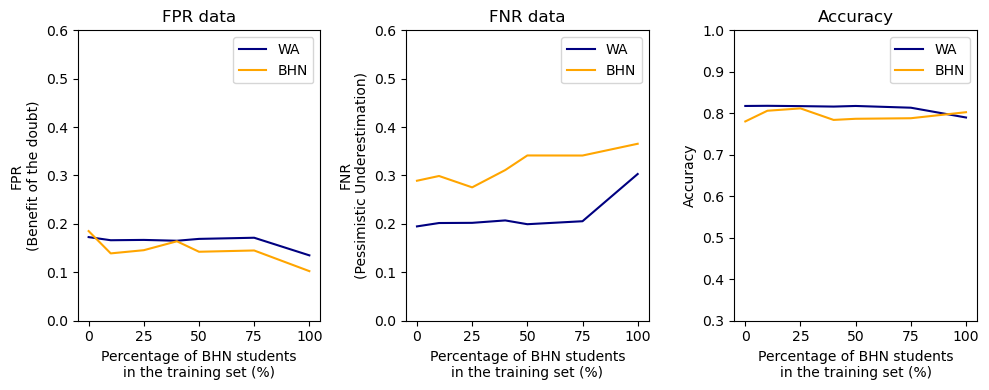

In [80]:
import matplotlib.pyplot as plt

x = [] 
y_FPR_WA = []
y_FPR_BHN = []
y_FNR_WA = []
y_FNR_BHN = []
y_ACC_WA = []
y_ACC_BHN = []

for ratio in target_bhn_ratios:
    x.append(ratio * 100)

    y_FPR_WA.append(wa_map[ratio][3])
    y_FPR_BHN.append(bhn_map[ratio][3])

    y_FNR_WA.append(wa_map[ratio][2])
    y_FNR_BHN.append(bhn_map[ratio][2])

    y_ACC_WA.append(wa_map[ratio][0])
    y_ACC_BHN.append(bhn_map[ratio][0])
    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# plot data
ax1.plot(x, y_FPR_WA, label="WA", color="navy")
ax1.plot(x, y_FPR_BHN, label="BHN", color="orange")

ax2.plot(x, y_FNR_WA, label="WA", color="navy")
ax2.plot(x, y_FNR_BHN, label="BHN", color="orange")

ax3.plot(x, y_ACC_WA, label="WA", color="navy")
ax3.plot(x, y_ACC_BHN, label="BHN", color="orange")

# add labels and title
ax1.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax1.set_ylabel("FPR\n(Benefit of the doubt)")
ax1.set_title("FPR data")
ax1.legend()
ax1.set_ylim(0, 0.6)

ax2.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax2.set_ylabel("FNR\n(Pessimistic Underestimation)")
ax2.set_title("FNR data")
ax2.legend()
ax2.set_ylim(0, 0.6)

ax3.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax3.set_ylabel("Accuracy")
ax3.set_title("Accuracy")
ax3.legend()
ax3.set_ylim(0.3, 1)

plt.tight_layout()
plt.show()
